# Imports

In [23]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax
from theano import function
from scipy.misc import imread
from data_preprocessing import *
from sklearn.linear_model import LogisticRegression
from lasagne.regularization import regularize_layer_params_weighted, l2, l1, regularize_layer_params

import sklearn
import theano
import time

import numpy as np
import theano.tensor as T
import os
import pickle
import lasagne
import itertools
import matplotlib
matplotlib.use("Pdf")
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [40]:
MEAN_VALUES = np.array([104, 117, 123], dtype=np.float32).reshape(1, 3, 1, 1)
 
def preprocess(img):
    return np.rollaxis(img, 2)[::-1][None] - MEAN_VALUES


def deprocess(img):
    return np.transpose((img + MEAN_VALUES)[0, ::-1], (1, 2, 0))


def featurize(X):
    data = [None] * len(X)

    for i, img in enumerate(X):
        img = proportional_resize(img)
        data[i] = features(preprocess(img)).ravel()

    return data


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Build simple model

In [41]:
def build_simple_model(input_shape):
    net = {}
    
    net['input'] = InputLayer((None, input_shape[2], input_shape[0], input_shape[1]))
    
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)

    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

# Load pretrained net params

In [42]:
with open('vgg19.pkl', 'rb') as f:
    params = pickle.load(f)

In [43]:
img_dir = 'leftImg8bit'
images_path = os.path.join(CITYSCAPESPATH, img_dir)

first_img_path = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(images_path)) for f in fn][0]
img = imread(first_img_path)
first_img = proportional_resize(img)
net = build_simple_model(first_img.shape)

In [44]:
last_vgg_layer = net['pool5']
lasagne.layers.set_all_param_values(last_vgg_layer, params['param values'][:32])

In [ ]:
input_X = T.tensor4('X')

output = lasagne.layers.get_output(last_vgg_layer, input_X, deterministic = True)
features = function([input_X], output)

# Data loading

In [8]:
def load_data(modes, *args, **kwargs):
    cities = get_cities(modes=modes)
    dataset = prepare_dataset(
            itertools.chain(*[zip(ReadFilePaths(mode, city, 'leftImg8bit'),
                                  ReadFilePaths(mode, city, 'gtFine', 'gtFine_color.png'),
                                  ReadFilePaths(mode, city, 'disparity'))
                            for mode in modes for city in cities[mode]]), *args, **kwargs)
    return zip(*dataset)

In [34]:
def load_data_huge(modes, *args, **kwargs):
    cities = get_cities(img_dir='train_extra/disparity', modes=modes)
    dataset = prepare_dataset(
            itertools.chain(*[zip(ReadFilePaths(mode, city, 'train_extra/leftImg8bit'),
                                  ReadFilePaths(mode, city, 'train_extra/gtCoarse', 'gtCoarse_color.png'),
                                  ReadFilePaths(mode, city, 'train_extra/disparity'))
                            for mode in modes for city in cities[mode]]), *args, **kwargs)
    return zip(*dataset)

In [16]:
%%time

rem_road = True

data_filename = 'data_rem_road.pkl' if rem_road else 'data_basic.pkl'

if os.path.exists(data_filename):
    with open(data_filename, 'rb') as f:
        X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
else:
    X_val, Seg_val, y_val = load_data(['val'], rem_road, 10)
    X_train, Seg_train, y_train = load_data(['train'], rem_road, 10)
    X_test, Seg_test, y_test = load_data(['test'], rem_road, 10)

    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    Seg_test = np.array(Seg_test)
    Seg_train = np.array(Seg_train)
    Seg_val = np.array(Seg_val)

    with open(data_filename, 'wb') as f:
        pickle.dump((X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test), f)

CPU times: user 3min 2s, sys: 9.84 s, total: 3min 12s
Wall time: 6min 9s


In [52]:
%%time

rem_road = False

data_filename = 'data_huge_rem_road.pkl' if rem_road else 'data_huge.pkl'

if os.path.exists(data_filename):
    with open(data_filename, 'rb') as f:
        X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
else:
    X_val, Seg_val, y_val = load_data(['val'], rem_road, 10)

    X_train, Seg_train, y_train = load_data(['train'], rem_road, 10)
    X_train_extra, Seg_train_extra, y_train_extra = load_data_huge(['train'], rem_road, 10)

    X_test, Seg_test, y_test = load_data(['test'], rem_road, 10)

    X_train = np.array(X_train + X_train_extra)
    Seg_train = np.array(Seg_train + Seg_train_extra)
    y_train = np.array(y_train + y_train_extra)
    X_val = np.array(X_val)
    Seg_val = np.array(Seg_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    Seg_test = np.array(Seg_test)
    y_test = np.array(y_test)    

    with open(data_filename, 'wb') as f:
        pickle.dump((X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test), f)

CPU times: user 8min 51s, sys: 1min 47s, total: 10min 38s
Wall time: 22min 38s


In [53]:
%%time
f1_val = featurize(X_val)
f1_train = featurize(X_train)
f1_test = featurize(X_test)
f2_val = featurize(Seg_val)
f2_train = featurize(Seg_train)
f2_test = featurize(Seg_test)

CPU times: user 24min 20s, sys: 11min 32s, total: 35min 52s
Wall time: 35min 17s


In [54]:
len(f1_train), f1_train[0].shape

(22972, (18432,))

In [55]:
with open('features_huge.pkl', 'wb') as f:
    pickle.dump((f1_train, f1_val, f1_test, f2_train, f2_val, f2_test), f)

In [ ]:
with open('features_huge.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)

In [51]:
with open('features_huge_rem_road.pkl', 'wb') as f:
    pickle.dump((f1_train, f1_val, f1_test, f2_train, f2_val, f2_test), f)

In [ ]:
with open('features_huge_rem_road.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)

In [16]:
with open('features_rem_road.pkl', 'wb') as f:
    pickle.dump((f1_train, f1_val, f1_test, f2_train, f2_val, f2_test), f)

In [ ]:
with open('features_rem_road.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)

In [12]:
with open('features_basic.pkl', 'wb') as f:
    pickle.dump((f1_train, f1_val, f1_test, f2_train, f2_val, f2_test), f)

In [11]:
with open('features_basic.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)

(array([  16.,   49.,   88.,  163.,  109.,  125.,  120.,  113.,  127.,
         106.,  132.,  134.,  115.,  195.,  295.,  368.,  252.,  131.,
         125.,  212.]),
 array([  14. ,   19.6,   25.2,   30.8,   36.4,   42. ,   47.6,   53.2,
          58.8,   64.4,   70. ,   75.6,   81.2,   86.8,   92.4,   98. ,
         103.6,  109.2,  114.8,  120.4,  126. ]),
 <a list of 20 Patch objects>)

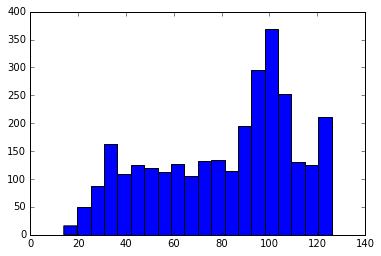

In [38]:
plt.hist(y_train, bins=20)

In [13]:
y_train

array([ 60, 105,  42, ...,  83,  18,  50], dtype=uint8)

In [14]:
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 50),
        np.percentile(y_train, 100) + 1]

In [51]:
bins

[14.0, 57.0, 89.0, 103.0, 127.0]

In [52]:
y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

(array([ 739.,    0.,    0.,  715.,    0.,    0.,  721.,    0.,    0.,  800.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

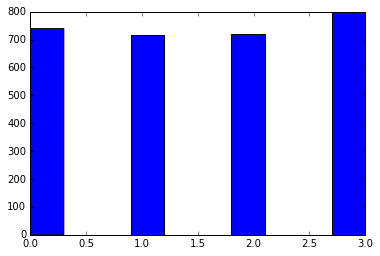

In [53]:
plt.hist(y_train)

# With the road

In [31]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.73199999999999998

# With the road + segmentation

In [32]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(np.hstack((np.array(f1_train), np.array(f2_train))), y_train).score(np.hstack((np.array(f1_val), np.array(f2_val))), y_val)

0.82399999999999995

# Road deleted

In [40]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(f1_train, y_train).score(f1_val, y_val)

0.88400000000000001

# Road deleted + segmentation

In [41]:
clf = LogisticRegression(C=0.005, penalty='l1')
clf.fit(np.hstack((np.array(f1_train), np.array(f2_train))), y_train).score(np.hstack((np.array(f1_val), np.array(f2_val))), y_val)

0.86799999999999999

# Network deleted road, classes

In [37]:
with open('data_rem_road.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_rem_road.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr3 = DropoutLayer(ll2, p=0.5)
ll3 = DenseLayer(dr3, num_units=1024, nonlinearity=lasagne.nonlinearities.elu)
dr4 = DropoutLayer(ll3, p=0.5)
ll4 = DenseLayer(dr4, num_units=512, nonlinearity=lasagne.nonlinearities.elu)
dr5 = DropoutLayer(ll4, p=0.5)
ll5 = DenseLayer(dr5, num_units=256, nonlinearity=lasagne.nonlinearities.elu)
dr6 = DropoutLayer(ll5, p=0.5)
percentile = DenseLayer(dr6, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-1
l1_penalty = regularize_layer_params(percentile, l1) * 1e-3
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b, W, b, W, b, W, b]
Epoch 1 of 30 took 1.998s
  training loss (in-iteration):		3749.619600
  train accuracy:		28.59 %
  validation accuracy:		26.00 %
Epoch 2 of 30 took 2.015s
  training loss (in-iteration):		3.113019
  train accuracy:		32.24 %
  validation accuracy:		46.60 %
Epoch 3 of 30 took 1.982s
  training loss (in-iteration):		2.176733
  train accuracy:		45.90 %
  validation accuracy:		49.40 %
Epoch 4 of 30 took 2.010s
  training loss (in-iteration):		1.896570
  train accuracy:		52.72 %
  validation accuracy:		58.00 %
Epoch 5 of 30 took 1.978s
  training loss (in-iteration):		1.765641
  train accuracy:		58.38 %
  validation accuracy:		52.20 %
Epoch 6 of 30 took 2.000s
  training loss (in-iteration):		1.671071
  train accuracy:		63.17 %
  validation accuracy:		62.00 %
Epoch 7 of 30 took 2.000s
  training loss (in-iteration):		1.551463
  train accuracy:		69.31 %
  validation accuracy:		55.20 %
Epoch 8 of 30 took 2.111s
  training loss (in-iteration):		1.477413
  t

KeyboardInterrupt: 

# Network with road, 5 classes

In [ ]:
with open('data_basic.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_basic.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

In [36]:
input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=2048, nonlinearity=lasagne.nonlinearities.elu)
dr3 = DropoutLayer(ll2, p=0.5)
ll3 = DenseLayer(dr3, num_units=1024, nonlinearity=lasagne.nonlinearities.elu)
dr4 = DropoutLayer(ll3, p=0.5)
ll4 = DenseLayer(dr4, num_units=512, nonlinearity=lasagne.nonlinearities.elu)
dr5 = DropoutLayer(ll4, p=0.5)
ll5 = DenseLayer(dr5, num_units=256, nonlinearity=lasagne.nonlinearities.elu)
dr6 = DropoutLayer(ll5, p=0.5)
percentile = DenseLayer(dr6, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-1
l1_penalty = regularize_layer_params(percentile, l1) * 1e-2
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.005)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 300 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b, W, b, W, b, W, b]
Epoch 1 of 300 took 2.036s
  training loss (in-iteration):		140.387504
  train accuracy:		31.28 %
  validation accuracy:		52.80 %
Epoch 2 of 300 took 2.016s
  training loss (in-iteration):		13.295092
  train accuracy:		55.17 %
  validation accuracy:		58.20 %
Epoch 3 of 300 took 2.002s
  training loss (in-iteration):		12.705572
  train accuracy:		62.45 %
  validation accuracy:		60.40 %
Epoch 4 of 300 took 2.003s
  training loss (in-iteration):		12.226186
  train accuracy:		68.86 %
  validation accuracy:		60.40 %
Epoch 5 of 300 took 2.002s
  training loss (in-iteration):		11.880651
  train accuracy:		71.07 %
  validation accuracy:		60.20 %
Epoch 6 of 300 took 2.014s
  training loss (in-iteration):		11.404465
  train accuracy:		79.07 %
  validation accuracy:		61.80 %
Epoch 7 of 300 took 2.018s
  training loss (in-iteration):		11.053822
  train accuracy:		84.86 %
  validation accuracy:		65.00 %
Epoch 8 of 300 took 1.896s
  training loss (in-iteration):	

KeyboardInterrupt: 

# Network deleted road, 5 classes, stacked with segs

In [9]:
with open('data_rem_road.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_rem_road.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
f1_train = np.hstack((np.array(f1_train), np.array(f2_train)))
f1_val = np.hstack((np.array(f1_val), np.array(f2_val)))
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=4096)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=4096)
dr3 = DropoutLayer(ll2, p=0.5)
percentile = DenseLayer(dr3, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-2
l1_penalty = regularize_layer_params(percentile, l1) * 1e-3
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b]


MemoryError: Error allocating 603979776 bytes of device memory (out of memory).
Apply node that caused the error: GpuDot22(GpuDimShuffle{1,0}.0, GpuElemwise{Composite{(i0 + (i0 * sgn(i1)))}}[(0, 0)].0)
Toposort index: 54
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(36864, 100), (100, 4096)]
Inputs strides: [(1, 36864), (4096, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuElemwise{Sqr}[(0, 0)](GpuDot22.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

# Network with road, 5 classes, stacked with segs

In [8]:
with open('data_basic.pkl', 'rb') as f:
    X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
    
with open('features_basic.pkl', 'rb') as f:
    f1_train, f1_val, f1_test, f2_train, f2_val, f2_test = pickle.load(f)
    
f1_train = np.hstack((np.array(f1_train), np.array(f2_train)))
f1_val = np.hstack((np.array(f1_val), np.array(f2_val)))
    
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

input_layer = InputLayer((None, f1_train[0].shape[0]))
ll1 = DenseLayer(input_layer, num_units=4096)
dr1 = DropoutLayer(ll1, p=0.5)
ll2 = DenseLayer(dr1, num_units=4096)
dr3 = DropoutLayer(ll2, p=0.5)
percentile = DenseLayer(dr3, num_units=len(set(y_train)), nonlinearity=softmax)

target_y = T.vector("target Y integer", dtype='int32')
input_X = T.matrix('X')

probs = lasagne.layers.get_output(percentile, input_X, deterministic = True)
y_predicted = np.argmax(probs, axis=1)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(percentile)
print(all_weights)

#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(probs, target_y).mean()
l2_penalty = regularize_layer_params(percentile, l2) * 1e-1
l1_penalty = regularize_layer_params(percentile, l1) * 1e-2
loss += l2_penalty + l1_penalty

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(probs, target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adagrad(loss, all_weights, learning_rate=0.01)

#function that computes loss and updates weights
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X, target_y],accuracy)

num_epochs = 30 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(f1_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets.astype(np.int32))
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(f1_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets.astype(np.int32))
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

[W, b, W, b, W, b]
Epoch 1 of 30 took 4.315s
  training loss (in-iteration):		4726.092065
  train accuracy:		24.38 %
  validation accuracy:		33.00 %
Epoch 2 of 30 took 4.367s
  training loss (in-iteration):		11.885494
  train accuracy:		30.03 %
  validation accuracy:		26.00 %
Epoch 3 of 30 took 4.157s
  training loss (in-iteration):		5.118199
  train accuracy:		30.03 %
  validation accuracy:		25.20 %
Epoch 4 of 30 took 4.156s
  training loss (in-iteration):		4.719048
  train accuracy:		33.24 %
  validation accuracy:		25.00 %
Epoch 5 of 30 took 4.154s
  training loss (in-iteration):		4.602650
  train accuracy:		33.83 %
  validation accuracy:		25.40 %
Epoch 6 of 30 took 4.158s
  training loss (in-iteration):		4.511264
  train accuracy:		34.45 %
  validation accuracy:		29.20 %
Epoch 7 of 30 took 4.156s
  training loss (in-iteration):		4.433514
  train accuracy:		35.31 %
  validation accuracy:		31.80 %
Epoch 8 of 30 took 4.153s
  training loss (in-iteration):		4.364174
  train accuracy:		3

# Visualization

In [11]:
from operator import itemgetter 

def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(10 * n_col, 5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def show_results(X, truth, answers, n_repr = 3):
    classes = ['very far', 'far', 'close', 'very close']
    titles = ['thuth:{0} - predicted:{1}'.format(classes[truth[i]], classes[answers[i]]) for i in range(len(truth))]
    
    to_draw = {}
    
    for c in classes:
        to_draw[c] = [] 
    
        for i, answer in enumerate(truth):
            if c == classes[answer]:
                to_draw[c].append(i)
                
            if len(to_draw[c]) >= n_repr:
                break
    
    plot_gallery(X[sum(to_draw.values(), [])], 
                 itemgetter(*sum(to_draw.values(), []))(titles), n_row= n_repr * len(classes) / 3, n_col=3)

# With road removal

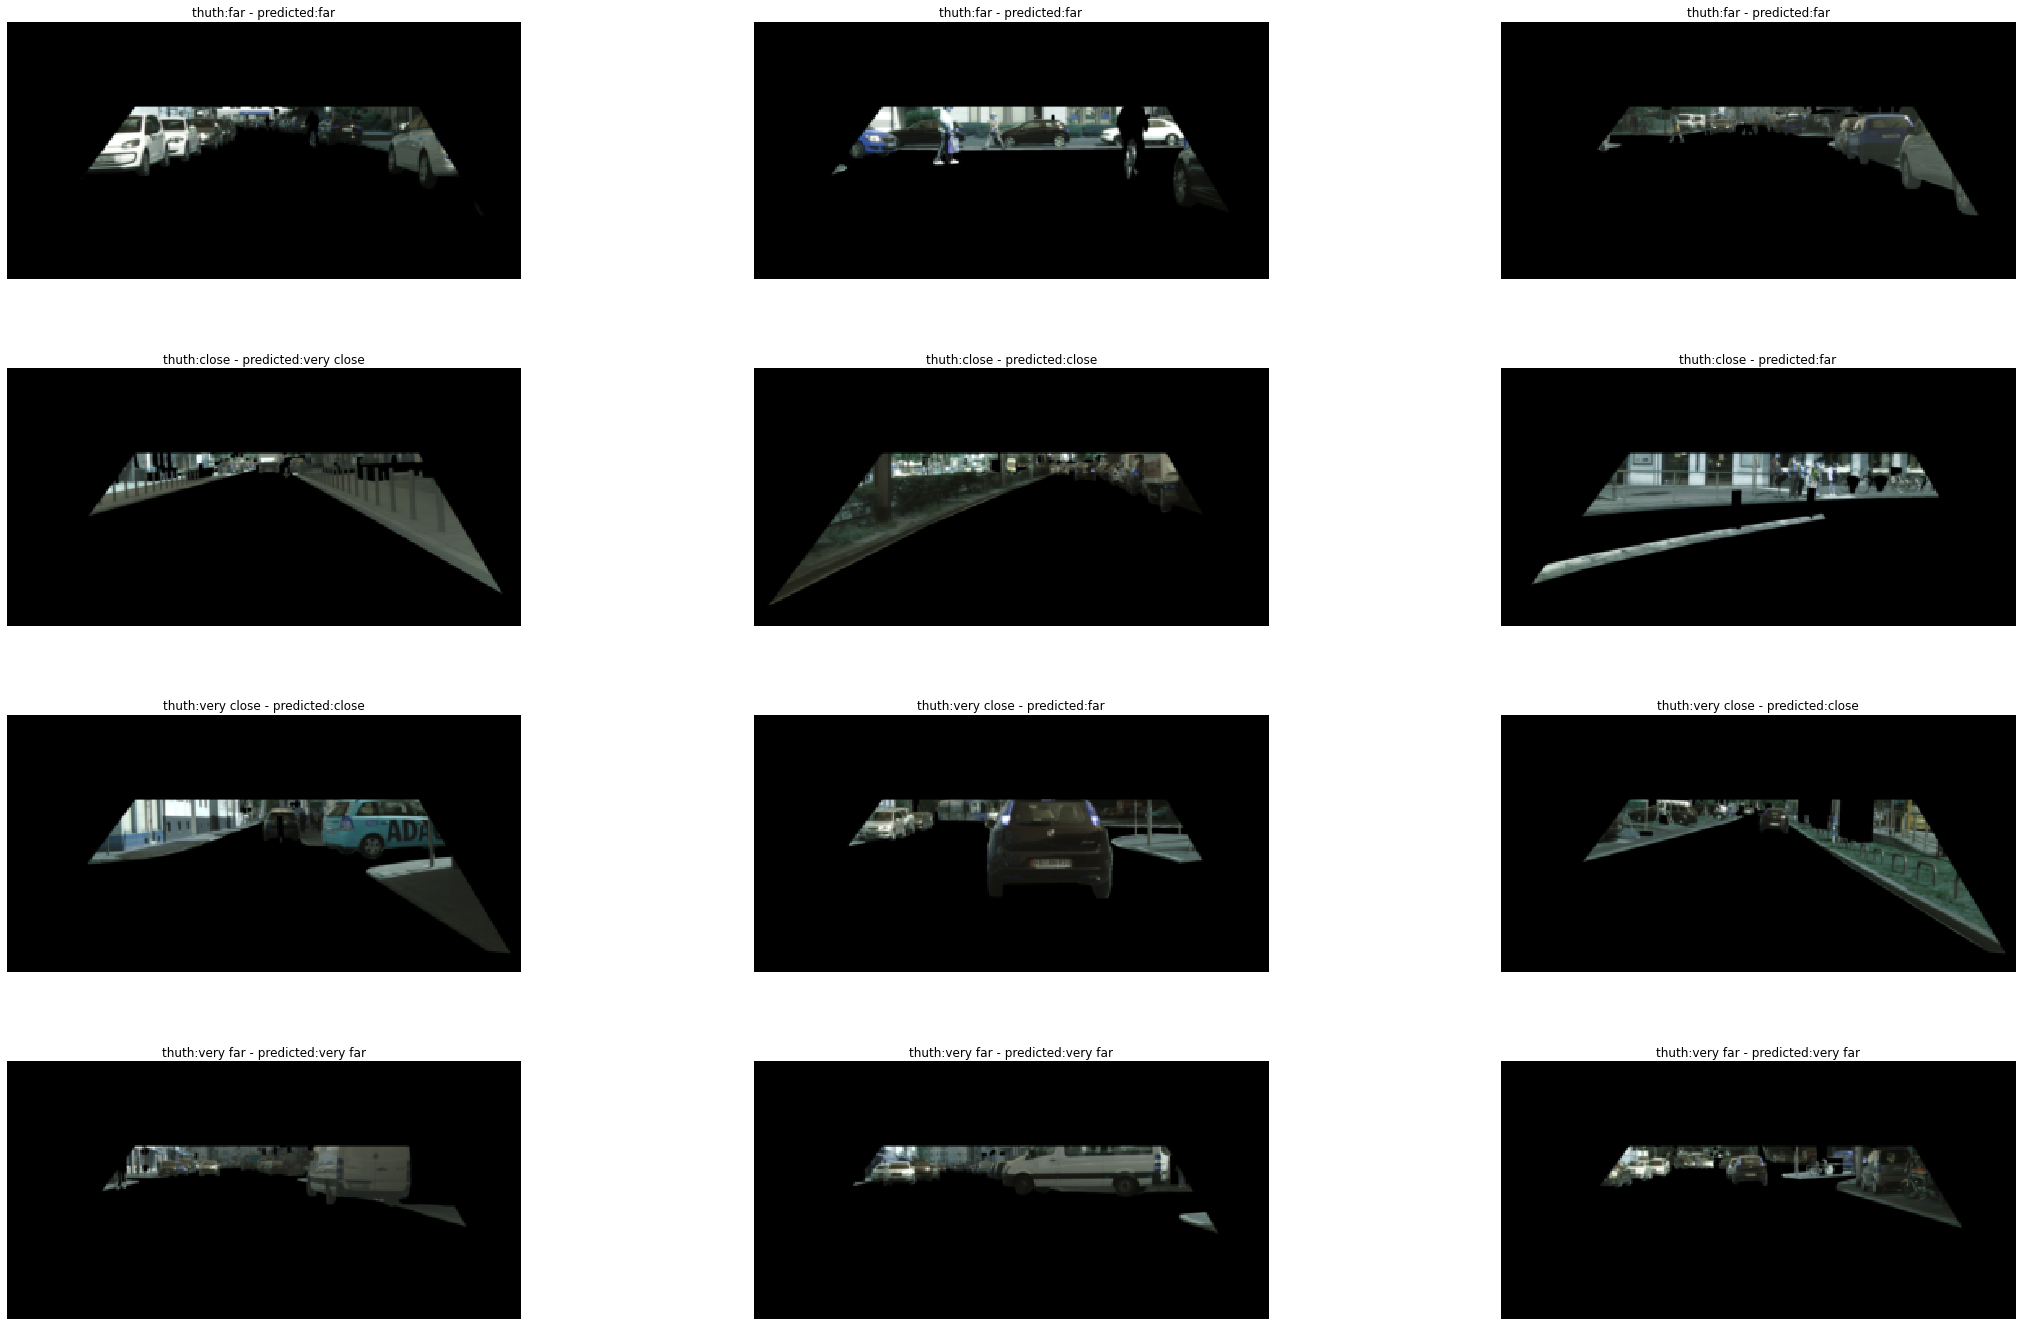

In [12]:
data_filename = 'data_rem_road.pkl'

if os.path.exists(data_filename):
    with open(data_filename, 'rb') as f:
        X_train, Seg_train, y_train, X_val, Seg_val, y_val, X_test, Seg_test, y_test = pickle.load(f)
        
bins = [np.percentile(y_train, 0),
        np.percentile(y_train, 25),
        np.percentile(y_train, 50),
        np.percentile(y_train, 75),
        np.percentile(y_train, 100) + 1]

y_train = np.digitize(y_train, bins) - 1
y_val = np.digitize(y_val, bins) - 1
y_test = np.digitize(y_test, bins) - 1

answers = [2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 3, 3, 0, 3,
2, 3, 0, 3, 0, 2, 2, 3, 1, 1, 3, 2, 0, 0, 3, 3, 2, 0, 0, 0, 1, 1, 0,
3, 0, 0, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0, 3, 0, 2, 3, 3, 1, 0, 3, 0, 0,
0, 0, 0, 0, 0, 3, 0, 1, 1, 3, 3, 3, 1, 1, 3, 2, 3, 3, 0, 3, 1, 3, 3,
3, 0, 0, 3, 2, 3, 2, 1, 3, 1, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 3, 0,
1, 1, 1, 3, 0, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 1, 0, 0, 0, 1, 1, 3,
3, 0, 3, 0, 0, 1, 3, 0, 3, 0, 3, 3, 0, 3, 3, 1, 3, 0, 0, 3, 3, 0, 0,
0, 0, 3, 0, 1, 1, 1, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
0, 2, 0, 1, 0, 0, 0, 3, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 1,
1, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 1, 1, 1, 0, 1, 3, 0,
0, 0, 3, 1, 0, 0, 1, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 1, 0, 0, 3,
1, 0, 1, 2, 2, 1, 3, 1, 3, 3, 3, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 2, 1,
1, 1, 2, 2, 2, 2, 0, 0, 2, 3, 3, 2, 2, 3, 2, 0, 1, 1, 1, 1, 1, 1, 0,
2, 0, 2, 3, 0, 1, 1, 0, 3, 0, 1, 0, 3, 3, 2, 3, 3, 2, 3, 3, 2, 1, 3,
2, 2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 2, 3, 3, 1, 1, 1, 0, 0, 1, 2, 3, 2,
2, 1, 1, 0, 2, 0, 0, 3, 1, 0, 2, 1, 3, 0, 0, 1, 3, 3, 0, 0, 0, 3, 0,
2, 3, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 1, 1, 3, 2, 2, 3, 2, 1, 2, 2, 2,
1, 0, 2, 0, 1, 3, 0, 1, 1, 2, 1, 2, 0, 1, 2, 2, 3, 3, 1, 2, 1, 2, 1,
2, 0, 0, 0, 2, 1, 0, 3, 2, 1, 3, 3, 0, 1, 0, 0, 1, 0, 2, 2, 1, 0, 2,
1, 2, 0, 3, 0, 3, 1, 0, 2, 1, 0, 2, 1, 1, 3, 0, 3, 0, 0, 2, 3, 1, 3,
0, 0, 0, 1, 0, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 2, 3, 1, 3, 1, 2, 0, 0,
1, 1, 2, 2, 3, 0, 3, 2, 1, 0, 2, 0, 0, 0, 1, 3, 2]

show_results(X_val, y_val, answers, 3)

In [15]:
features(preprocess(X_train[0])).ravel().shape

(18432,)